### Evaluating performance of different classifiers based on patient metadata

- Age
- Sex
- Diagnosis source
- Lesion location

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

from sklearn.metrics import precision_score, recall_score, accuracy_score

from scipy.stats import ttest_ind, chi2_contingency

In [30]:
df_pt = pd.read_csv('Data/archive/HAM10000_metadata.csv')

In [32]:
df_pt.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [99]:
len(df_pt['image_id'].unique())

10015

In [100]:
dx_counts = df_pt['dx'].value_counts()

In [101]:
df_dx = df_pt[['image_id', 'dx']]

np.random.seed(10)
df_dx['pred_dx'] = np.random.choice(a=dx_counts.index, 
                             size=len(df_pt), 
                             p=(dx_counts.values/len(df_pt)),
                             replace=True)

In [102]:
(dx_counts/len(df_pt)).round(3)

nv       0.669
mel      0.111
bkl      0.110
bcc      0.051
akiec    0.033
vasc     0.014
df       0.011
Name: dx, dtype: float64

Pretend this dataframe is some derived output from our classifiers:

In [103]:
df_dx

,image_id,dx,pred_dx
0,ISIC_0027419,bkl,mel
1,ISIC_0025030,bkl,nv
2,ISIC_0026769,bkl,nv
3,ISIC_0025661,bkl,mel
4,ISIC_0031633,bkl,nv
...,...,...,...
10010,ISIC_0033084,akiec,nv
10011,ISIC_0033550,akiec,nv
10012,ISIC_0033536,akiec,nv
10013,ISIC_0032854,akiec,bcc


Identify misclassifications

In [104]:
df_dx['correct'] = (df_dx['dx'] == df_dx['pred_dx']).astype(int)


In [105]:
df_dx['correct'].value_counts()/len(df_dx)

0    0.512531
1    0.487469
Name: correct, dtype: float64

Binning diagnoses into "dangerous" vs not

In [106]:
df_dx['true_danger_dx'] = (df_dx['dx'].isin(['mel', 'bcc', 'akiec'])).astype(int)
df_dx['pred_danger_dx'] = (df_dx['pred_dx'].isin(['mel', 'bcc', 'akiec'])).astype(int)
df_dx['correct_danger'] = (df_dx['true_danger_dx'] == df_dx['pred_danger_dx']).astype(int)

In [107]:
df_dx['correct_danger'].value_counts()/len(df_dx)

1    0.694958
0    0.305042
Name: correct_danger, dtype: float64

In [108]:
df_dx.head()

,image_id,dx,pred_dx,correct,true_danger_dx,pred_danger_dx,correct_danger
0,ISIC_0027419,bkl,mel,0,0,1,0
1,ISIC_0025030,bkl,nv,0,0,0,1
2,ISIC_0026769,bkl,nv,0,0,0,1
3,ISIC_0025661,bkl,mel,0,0,1,0
4,ISIC_0031633,bkl,nv,0,0,0,1


#### Join with patient metadata

In [109]:
dfj = df_dx.merge(df_pt[['image_id', 'age', 'sex', 'localization', 'dx_type']], on='image_id')
dfj.head()

,image_id,dx,pred_dx,correct,true_danger_dx,pred_danger_dx,correct_danger,age,sex,localization,dx_type
0,ISIC_0027419,bkl,mel,0,0,1,0,80.0,male,scalp,histo
1,ISIC_0025030,bkl,nv,0,0,0,1,80.0,male,scalp,histo
2,ISIC_0026769,bkl,nv,0,0,0,1,80.0,male,scalp,histo
3,ISIC_0025661,bkl,mel,0,0,1,0,80.0,male,scalp,histo
4,ISIC_0031633,bkl,nv,0,0,0,1,75.0,male,ear,histo


In [110]:
corr_df = dfj[dfj['correct'] == 1]
incorr_df = dfj[dfj['correct'] == 0]

In [111]:
len(corr_df), len(incorr_df)

(4882, 5133)

In [118]:
(corr_df['sex'].value_counts()/len(corr_df)).round(3)
(incorr_df['sex'].value_counts()/len(corr_df)).round(3)

male       0.583
female     0.463
unknown    0.005
Name: sex, dtype: float64

Incorrect classifications are more likely __male__

(0, 100)

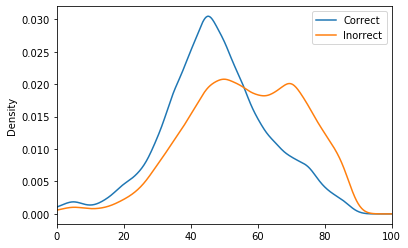

In [114]:
corr_df['age'].plot(kind='kde', label='Correct')
incorr_df['age'].plot(kind='kde', label='Inorrect')
plt.legend()
plt.xlim([0, 100])

Incorrect classifications are more likely to be __older__

In [115]:
(corr_df['dx_type'].value_counts()).sort_index()

confocal        7
consensus     359
follow_up    2541
histo        1975
Name: dx_type, dtype: int64

In [117]:
(incorr_df['dx_type'].value_counts()).sort_index()

confocal       62
consensus     543
follow_up    1163
histo        3365
Name: dx_type, dtype: int64

Incorrect classifications are more likely to be from a histo test - maybe false designations during the test?

localization

confusion matrices (dx and binned dx)

metric calculations

In [74]:
df_pt['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [155]:
chi2_contingency?

______

### Loading classification results

#### From Nicholas - SVM

Melanoma vs non-melanoma

In [40]:
df_mel = pd.read_csv('ClassifierResults/LogitWrapper_SVMFit.csv')

In [64]:
df_mel['Correct'] = (df_mel['Logit_Fit'] == df_mel['Ground_Truth']).astype(int)

In [57]:
df_mel['Correct'].sum()/len(df_mel)

0.8093525179856115

In [54]:
recall_score(y_true=df_mel['Ground_Truth'] , y_pred=df_mel['Logit_Fit'])

0.5838323353293413

In [62]:
accuracy_score(y_true=df_mel['Ground_Truth'] , y_pred=df_mel['Logit_Fit'])

0.8093525179856115

In [63]:
df_mel['Logit_Fit'].value_counts()

0    619
1    215
Name: Logit_Fit, dtype: int64

In [65]:
df_mel['Correct'].value_counts()

1    675
0    159
Name: Correct, dtype: int64

In [69]:
df_mel['Ground_Truth'].value_counts()

0    500
1    334
Name: Ground_Truth, dtype: int64

In [67]:
df_mel[df_mel['Ground_Truth'] == 1]

,Unnamed: 0,Image_ID,One_Class_Pred,Nu_Class_Pred,Logit_Fit,Ground_Truth,Correct
500,1212,ISIC_0030950,1,1,1,1,1
501,1213,ISIC_0025195,1,1,1,1,1
502,1218,ISIC_0026652,0,1,1,1,1
503,1225,ISIC_0029885,1,1,1,1,1
504,1228,ISIC_0025409,0,1,1,1,1
...,...,...,...,...,...,...,...
829,23121,ISIC_0030261,1,0,0,1,0
830,23141,ISIC_0028994,1,0,0,1,0
831,23181,ISIC_0032696,1,0,0,1,0
832,23191,ISIC_0029466,1,0,0,1,0


And multiclass classification using SVM

In [16]:
df_mult = pd.read_csv('ClassifierResults/SVM_AllCat.csv')

In [27]:
df_mult.head()

,Unnamed: 0,Image_ID,Multi__Class_Pred,Ground_Truth
0,3,ISIC_0026769,1,2
1,8,ISIC_0029068,4,2
2,11,ISIC_0025276,4,2
3,12,ISIC_0029396,4,2
4,15,ISIC_0032417,4,2


### From Isaac - CNN

In [19]:
df_cnn = pd.read_csv('ClassifierResults/test.csv')

Stripping off file type to get image ID

In [24]:
df_cnn['Image_ID'] = df_cnn['Unnamed: 0'].apply(lambda x: x[:-4])

In [28]:
df_cnn.head()

,Unnamed: 0,prediction,Image_ID
0,ISIC_0024470.jpg,3,ISIC_0024470
1,ISIC_0024522.jpg,5,ISIC_0024522
2,ISIC_0024710.jpg,2,ISIC_0024710
3,ISIC_0024913.jpg,5,ISIC_0024913
4,ISIC_0025331.jpg,1,ISIC_0025331


In [80]:
df_cnn = df_cnn.merge(df_pt[['image_id', 'dx']], left_on='Image_ID', right_on='image_id', how='inner')

In [93]:
df_cnn = df_cnn.rename(columns={'dx': 'dx_true_n'})

In [94]:
df_cnn

,Unnamed: 0,prediction,Image_ID,dx_pred_n,image_id,dx_true_n
0,ISIC_0024470.jpg,3,ISIC_0024470,df,ISIC_0024470,akiec
1,ISIC_0024522.jpg,5,ISIC_0024522,nv,ISIC_0024522,akiec
2,ISIC_0024710.jpg,2,ISIC_0024710,bkl,ISIC_0024710,akiec
3,ISIC_0024913.jpg,5,ISIC_0024913,nv,ISIC_0024913,akiec
4,ISIC_0025331.jpg,1,ISIC_0025331,bcc,ISIC_0025331,akiec
...,...,...,...,...,...,...
1487,ISIC_0032409.jpg,5,ISIC_0032409,nv,ISIC_0032409,vasc
1488,ISIC_0032692.jpg,5,ISIC_0032692,nv,ISIC_0032692,vasc
1489,ISIC_0032839.jpg,5,ISIC_0032839,nv,ISIC_0032839,vasc
1490,ISIC_0033230.jpg,5,ISIC_0033230,nv,ISIC_0033230,vasc


In [89]:
(df_cnn['dx_pred_n'] == df_cnn['dx']).astype(int).sum()/len(df_cnn)

0.3156836461126005

In [33]:
df_pt.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [34]:
df_pt[df_pt['image_id'].isin(df_cnn['Image_ID'].values)]

,lesion_id,image_id,dx,dx_type,age,sex,localization
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
31,HAM_0005772,ISIC_0031159,bkl,histo,60.0,female,face
60,HAM_0003021,ISIC_0031468,bkl,histo,75.0,female,face
62,HAM_0000959,ISIC_0029288,bkl,histo,75.0,female,face
71,HAM_0004341,ISIC_0031967,bkl,histo,70.0,female,scalp
...,...,...,...,...,...,...,...
9954,HAM_0001386,ISIC_0027668,akiec,histo,60.0,male,scalp
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face
9966,HAM_0000361,ISIC_0032199,akiec,histo,60.0,female,face
10004,HAM_0005579,ISIC_0029309,akiec,histo,80.0,male,face


In [35]:
len(df_cnn)

1492

In [39]:
df_pt[df_pt['image_id'].isin(df_mult['Image_ID'].values)]

,lesion_id,image_id,dx,dx_type,age,sex,localization
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
10,HAM_0001396,ISIC_0025276,bkl,histo,55.0,female,trunk
11,HAM_0004234,ISIC_0029396,bkl,histo,85.0,female,chest
14,HAM_0001949,ISIC_0032417,bkl,histo,70.0,male,trunk
...,...,...,...,...,...,...,...
9994,HAM_0000193,ISIC_0030877,akiec,histo,60.0,female,face
10002,HAM_0006442,ISIC_0032947,akiec,histo,70.0,male,hand
10003,HAM_0004592,ISIC_0029141,akiec,histo,60.0,female,face
10004,HAM_0005579,ISIC_0029309,akiec,histo,80.0,male,face


In [70]:
dx_map_I = {
    0: 'akiec',
    1: 'bcc',
    2: 'bkl',
    3: 'df',
    4: 'mel',
    5: 'nv',
    6: 'vasc'
}

dx_map_N = {
    0: 'akiec',
    1: 'bcc',
    2: 'bkl',
    3: 'df',
    4: 'nv',
    5: 'vasc',
    6: 'mel'
}

In [91]:
df_mult['dx_pred_n'] = df_mult['Multi__Class_Pred'].map(dx_map_N)
df_mult['dx_true_n'] = df_mult['Ground_Truth'].map(dx_map_N)

df_cnn['dx_pred_n'] = df_cnn['prediction'].map(dx_map_I)


In [92]:
df_mult

,Unnamed: 0,Image_ID,Multi__Class_Pred,Ground_Truth,dx_pred_n,dx_true_n
0,3,ISIC_0026769,1,2,bcc,bkl
1,8,ISIC_0029068,4,2,nv,bkl
2,11,ISIC_0025276,4,2,nv,bkl
3,12,ISIC_0029396,4,2,nv,bkl
4,15,ISIC_0032417,4,2,nv,bkl
...,...,...,...,...,...,...
3000,9995,ISIC_0030877,2,0,bkl,akiec
3001,10003,ISIC_0032947,4,0,nv,akiec
3002,10004,ISIC_0029141,2,0,bkl,akiec
3003,10005,ISIC_0029309,4,0,nv,akiec


In [238]:
df_mult['dx_true_n'].unique()

array(['bkl', 'df', 'mel', 'vasc', 'bcc', 'nv', 'akiec'], dtype=object)

In [292]:
import matplotlib as mpl

COLOR = 'lightgray'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

In [302]:
def get_misclf_stats(df_dx, df_pt, dx_label, pred_dx_label, image_name='image_id'):

    df_dx['correct'] = (df_dx[dx_label] == df_dx[pred_dx_label]).astype(int)
    df_dx['true_danger_dx'] = (df_dx[dx_label].isin(['mel', 'bcc', 'akiec'])).astype(int)
    df_dx['pred_danger_dx'] = (df_dx[pred_dx_label].isin(['mel', 'bcc', 'akiec'])).astype(int)
    df_dx['correct_danger'] = (df_dx['true_danger_dx'] == df_dx['pred_danger_dx']).astype(int)

    dfj = df_dx.merge(df_pt[[image_name, 'age', 'sex', 'localization', 'dx_type']], on=image_name)
    
    # Separate into correct and incorrect classifications
    corr_df = dfj[dfj['correct'] == 1]
    incorr_df = dfj[dfj['correct'] == 0]
    
    print('N Correct: %d'%len(corr_df))
    print('N Incorrect: %d\n'%len(incorr_df))
    
    # Age
    plt.figure(1)
    
    corr_df['age'].plot(kind='kde', label='Correct')
    incorr_df['age'].plot(kind='kde', label='Incorrect')
    leg = plt.legend()
    for text in leg.get_texts():
        text.set_color("black")
    plt.title('Multi-Classification, Age Distributions')
    plt.xlabel('Age (years)')
    plt.xlim([0, 100])
    
    print('Correct (age): %.2f'%corr_df['age'].mean())
    print('Incorrect (age): %.2f'%incorr_df['age'].mean())
    
    print('Age p-value: %f\n'%(ttest_ind(corr_df['age'], incorr_df['age'], nan_policy='omit', equal_var=True).pvalue))
    #print('here')
    #print((incorr_df['sex'].value_counts()/len(incorr_df)))
    
    
    # Sex
    sex_corr = corr_df['sex'].value_counts().sort_index()
    sex_incorr = incorr_df['sex'].value_counts().sort_index()
    
    print('Correct (sex): \n%s'%(sex_corr/len(corr_df)).round(3))
    print('Incorrect (sex): \n%s'%(sex_incorr/len(incorr_df)).round(3))
    
    print('p-value: %f'%(chi2_contingency(pd.concat([sex_corr, sex_incorr], axis=1).fillna(0).values)[1]))
    
    
    
    # Diagnosis source
    dxtype_corr = (corr_df['dx_type'].value_counts()).sort_index()
    dxtype_incorr = (incorr_df['dx_type'].value_counts()).sort_index()
    
    print('\nCorrect (dx source) \n%s'%(dxtype_corr/len(corr_df)))
    print('\nIncorrect (dx source) \n%s'%(dxtype_incorr/len(incorr_df)))
    
    print('p-value: %f'%(chi2_contingency(pd.concat([dxtype_corr, dxtype_incorr], axis=1).fillna(0).values)[1]))
    
    
    # Localization
    top_locs = ['face', 'abdomen', 'upper extremity', 'trunk', 'lower extremity', 'back']
    
    
    dxloc_corr = (corr_df['localization'].value_counts()).sort_index()
    dxloc_incorr = (incorr_df['localization'].value_counts()).sort_index()
    
    
    
    print('\nCorrect (localization) \n%s'%(dxloc_corr/len(corr_df)).round(3))
    print('Incorrect (localization \n%s)'%(dxloc_incorr/len(incorr_df)).round(3))
    
    
    
    loc_df = pd.concat([(dxloc_corr/len(corr_df)).loc[top_locs], (dxloc_incorr/len(incorr_df)).loc[top_locs]], axis=1)
    loc_df.columns = ['Correct', 'Incorrect']
    
    #plt.figure(2, figsize=[6, 6])
    
    loc_df.plot(kind='barh', figsize=[6, 4]) 
    plt.title("Multi-Classification, Location Distributions")
    plt.xlabel("Proportion")
    leg = plt.legend()
    for text in leg.get_texts():
        text.set_color("black")
    
    
    
    
    print('p-value: %f'%(chi2_contingency(pd.concat([dxloc_corr, dxloc_incorr], axis=1).fillna(0).values)[1]))
    
    
    
    print('\n\n------ Checking "danger" level -------\n\n')
    
    
    
    # Separate into correct and incorrect classifications
    corr_df = dfj[dfj['correct_danger'] == 1]
    incorr_df = dfj[dfj['correct_danger'] == 0]
    
    print('N Correct: %d'%len(corr_df))
    print('N Incorrect: %d\n'%len(incorr_df))
    
    # Age
    
    
    plt.figure(3)
    
    corr_df['age'].plot(kind='kde', label='Correct')
    incorr_df['age'].plot(kind='kde', label='Incorrect')
    plt.title('Binned "Danger", Age Distributions')
    plt.xlabel('Age (years)')
    leg = plt.legend()
    for text in leg.get_texts():
        text.set_color("black")
    plt.xlim([0, 100])
    
    print('Correct (age): %.2f'%corr_df['age'].mean())
    print('Incorrect (age): %.2f'%incorr_df['age'].mean())
    
    print('Age p-value: %f\n'%(ttest_ind(corr_df['age'], incorr_df['age'], nan_policy='omit', equal_var=True).pvalue))
    #print('here')
    #print((incorr_df['sex'].value_counts()/len(incorr_df)))
    
    
    # Sex
    sex_corr = corr_df['sex'].value_counts().sort_index()
    sex_incorr = incorr_df['sex'].value_counts().sort_index()
    
    print('Correct (sex): \n%s'%(sex_corr/len(corr_df)).round(3))
    print('Incorrect (sex): \n%s'%(sex_incorr/len(incorr_df)).round(3))
    
    print('p-value: %f'%(chi2_contingency(pd.concat([sex_corr, sex_incorr], axis=1).fillna(0).values)[1]))
    
    
    
    # Diagnosis source
    dxtype_corr = (corr_df['dx_type'].value_counts()).sort_index()
    dxtype_incorr = (incorr_df['dx_type'].value_counts()).sort_index()
    
    print('\nCorrect (dx source) \n%s'%(dxtype_corr/len(corr_df)))
    print('\nIncorrect (dx source) \n%s'%(dxtype_incorr/len(incorr_df)))
    
    print('p-value: %f'%(chi2_contingency(pd.concat([dxtype_corr, dxtype_incorr], axis=1).fillna(0).values)[1]))
    
    
    # Localization
    top_locs = ['face', 'abdomen', 'upper extremity', 'trunk', 'lower extremity', 'back']
    
    
    dxloc_corr = (corr_df['localization'].value_counts()).sort_index()
    dxloc_incorr = (incorr_df['localization'].value_counts()).sort_index()
    
    
    
    loc_df = pd.concat([(dxloc_corr/len(corr_df)).loc[top_locs], (dxloc_incorr/len(incorr_df)).loc[top_locs]], axis=1)
    loc_df.columns = ['Correct', 'Incorrect']
    
    plt.figure(4)
    loc_df.plot(kind='barh', figsize=[6, 4]) 
    plt.title('Binned "Danger", Locations')
    plt.xlabel('Proportion')
    leg = plt.legend()
    for text in leg.get_texts():
        text.set_color("black")
    
    print('\nCorrect (localization) \n%s'%(dxloc_corr/len(corr_df)).round(3))
    print('Incorrect (localization \n%s)'%(dxloc_incorr/len(incorr_df)).round(3))
    
    
    print('p-value: %f'%(chi2_contingency(pd.concat([dxloc_corr, dxloc_incorr], axis=1).fillna(0).values)[1]))
    
    
    
    
    
    

CNN

N Correct: 471
N Incorrect: 1021

Correct (age): 49.27
Incorrect (age): 52.46
Age p-value: 0.000408

Correct (sex): 
female     0.480
male       0.510
unknown    0.011
Name: sex, dtype: float64
Incorrect (sex): 
female     0.405
male       0.592
unknown    0.003
Name: sex, dtype: float64
p-value: 0.003136

Correct (dx source) 
confocal     0.004246
consensus    0.084926
follow_up    0.619958
histo        0.290870
Name: dx_type, dtype: float64

Incorrect (dx source) 
confocal     0.005877
consensus    0.080313
follow_up    0.458374
histo        0.455436
Name: dx_type, dtype: float64
p-value: 0.000000

Correct (localization) 
abdomen            0.136
back               0.180
chest              0.021
ear                0.008
face               0.047
foot               0.030
genital            0.004
hand               0.006
lower extremity    0.206
neck               0.013
scalp              0.015
trunk              0.214
unknown            0.032
upper extremity    0.087
Name: localization

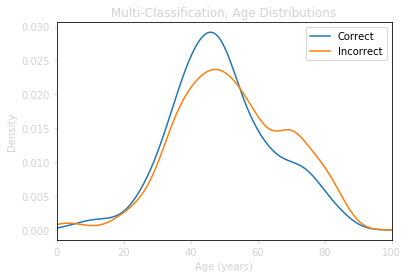

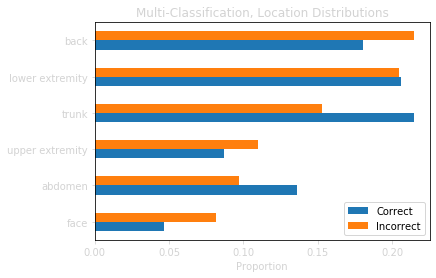

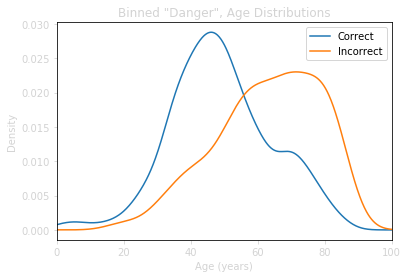

<Figure size 432x288 with 0 Axes>

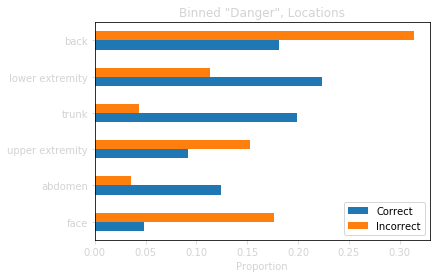

In [303]:
get_misclf_stats(df_cnn, df_pt, dx_label='dx_true_n', pred_dx_label='dx_pred_n')

In [251]:
df_mult = df_mult.rename(columns={'Image_ID': 'image_id'})

N Correct: 2164
N Incorrect: 841

Correct (age): 48.26
Incorrect (age): 61.53
Age p-value: 0.000000

Correct (sex): 
female     0.484
male       0.509
unknown    0.007
Name: sex, dtype: float64
Incorrect (sex): 
female     0.395
male       0.604
unknown    0.001
Name: sex, dtype: float64
p-value: 0.000005

Correct (dx source) 
confocal     0.006932
consensus    0.073013
follow_up    0.507856
histo        0.412200
Name: dx_type, dtype: float64

Incorrect (dx source) 
confocal     0.011891
consensus    0.131986
histo        0.856124
Name: dx_type, dtype: float64
p-value: 0.000000

Correct (localization) 
abdomen            0.126
back               0.218
chest              0.029
ear                0.006
face               0.041
foot               0.036
genital            0.006
hand               0.009
lower extremity    0.218
neck               0.010
scalp              0.006
trunk              0.175
unknown            0.031
upper extremity    0.089
Name: localization, dtype: float64
Incor

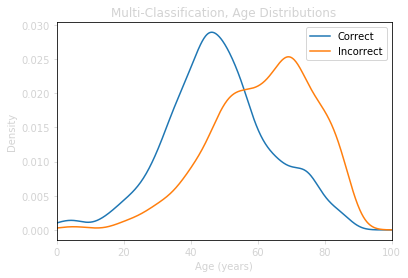

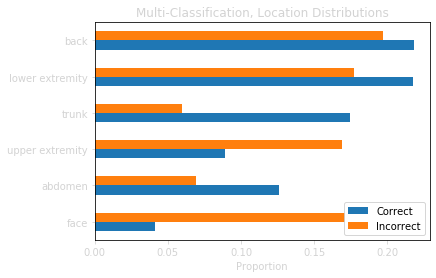

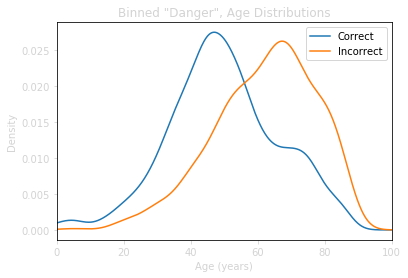

<Figure size 432x288 with 0 Axes>

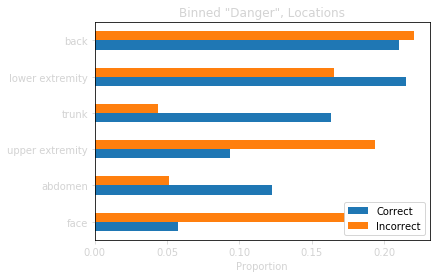

In [304]:
get_misclf_stats(df_mult, df_pt, dx_label='dx_true_n', pred_dx_label='dx_pred_n')

In [253]:
df_mult['correct']

0       0
1       0
2       0
3       0
4       0
       ..
3000    0
3001    0
3002    0
3003    0
3004    0
Name: correct, Length: 3005, dtype: int64